In [7]:
import sys
import os
import pandas as pd
import numpy as np
sys.path.append('/root/barcode/')
sys.path.append('../')
from BarcodeScanner import tree_and_clustering, base_barcode
from itertools import product, combinations
from sklearn.linear_model import LinearRegression
import timeit
from datasets import Dataset
from math import sqrt  
def gen_X(num_var: int, sample_size : int):
    data_dictionary = {}
    for i in range(num_var):
        var_name = "x" + f"{i + 1}"
        data_dictionary[var_name] = list(np.random.binomial(1, .5, sample_size))
    return pd.DataFrame(data_dictionary)

def gen_full_X(num_var: int, sample_size :int, gen_y = None):
    raw_X = gen_X(num_var = num_var, sample_size = sample_size)
    if gen_y is not None:
        y = raw_X.apply(gen_y, axis = 1)
    colnames = raw_X.columns
    for k in range(2, len(colnames)+ 1):
        interaction_generator = combinations(colnames, k)
        for interaction_tuple in interaction_generator:
            new_colname = "*".join(interaction_tuple)
            raw_X[new_colname] = raw_X[list(interaction_tuple)].apply(np.prod, axis = 1)
    if gen_y is not None:
        return raw_X, y
    else:
        return raw_X

In [20]:
gen_X(5, 300)

,x1,x2,x3,x4,x5
0,0,1,0,1,1
1,1,0,1,1,1
2,1,0,0,1,1
3,0,1,0,0,1
4,1,1,1,0,0
...,...,...,...,...,...
295,1,0,0,1,1
296,0,1,1,1,0
297,1,0,0,1,0
298,1,0,0,0,1


In [8]:
def gen_y(seq, error_var = 2):
    y = 1 + seq.x1 + seq.x2 + seq.x3 + seq.x1 * seq.x2 + seq.x1 * seq.x3 
    y += np.random.normal(scale = sqrt(error_var))
    return y

In [45]:
X, y = gen_full_X(4, 1000, gen_y)

In [46]:
from sklearn.linear_model import Lasso

In [47]:
reg = Lasso(alpha = 0.01)

In [48]:
reg.fit(X, y)

Lasso(alpha=0.01)

In [49]:
reg.coef_

array([ 0.81358894,  0.93007916,  0.74961681, -0.        ,  0.97775732,
        1.25756352,  0.        ,  0.        ,  0.        ,  0.09880569,
        0.        ,  0.0063066 ,  0.        , -0.        ,  0.        ])

In [50]:
X.columns.str.replace('x','x_')

Index(['x_1', 'x_2', 'x_3', 'x_4', 'x_1*x_2', 'x_1*x_3', 'x_1*x_4', 'x_2*x_3',
       'x_2*x_4', 'x_3*x_4', 'x_1*x_2*x_3', 'x_1*x_2*x_4', 'x_1*x_3*x_4',
       'x_2*x_3*x_4', 'x_1*x_2*x_3*x_4'],
      dtype='object')

In [115]:
coef = []
from tqdm import tqdm
for alpha in tqdm(range(1, 601)):
    alpha /= 1000
    reg = Lasso(alpha = alpha)
    reg.fit(X, y)
    coef.append(reg.coef_)

100%|██████████| 600/600 [00:01<00:00, 594.35it/s]


In [116]:
df = pd.DataFrame(coef, columns = X.columns.str.replace('x','x_'))

In [118]:
df['alpha'] = [x / 1000 for x in range(1, 601)]

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
df = df.melt(id_vars = 'alpha', value_name = 'coefficient estimates', var_name = 'variables')

In [121]:
df

,alpha,variables,coefficient estimates
0,0.001,x_1,0.866999
1,0.002,x_1,0.870616
2,0.003,x_1,0.854343
3,0.004,x_1,0.840220
4,0.005,x_1,0.832294
...,...,...,...
8995,0.596,x_1*x_2*x_3*x_4,0.000000
8996,0.597,x_1*x_2*x_3*x_4,0.000000
8997,0.598,x_1*x_2*x_3*x_4,0.000000
8998,0.599,x_1*x_2*x_3*x_4,0.000000


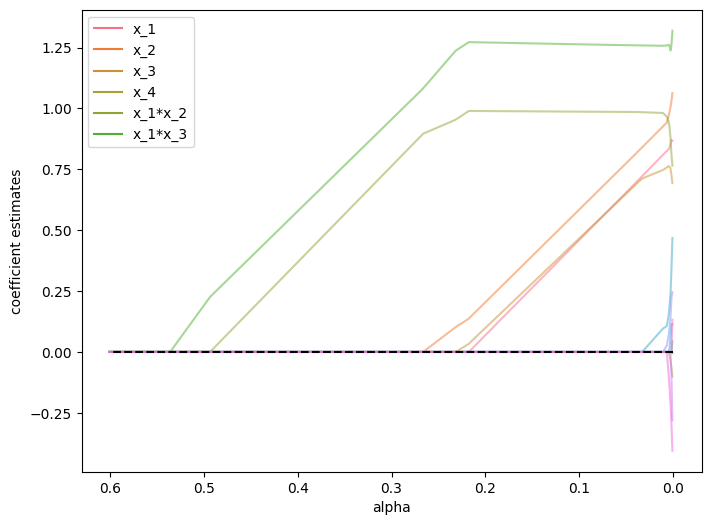

In [122]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
sns.lineplot(data = df, x = 'alpha', y = 'coefficient estimates', hue = 'variables', ax = ax, alpha = 0.5)
ax.invert_xaxis()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:6], labels[:6])
ax.hlines(0, xmax = 0.6, xmin = 0, colors = 'black', linestyles= '--')
fig.savefig('Lasso_graph.png')